# 0. Setup paths

In [85]:
import os

#CUSTOM_MODEL_NAME = 'my_ssd_mobnet'  # If further training of model is done
MODEL_DATE = '20200711'
MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
MODEL_TAR_FILENAME = MODEL_NAME + '.tar.gz'
MODELS_DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/'
MODEL_DOWNLOAD_LINK = MODELS_DOWNLOAD_BASE + MODEL_DATE + '/' + MODEL_TAR_FILENAME

# Workspace paths to setup directory
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
}

# Model-specific paths
PATH_TO_MODEL_TAR = os.path.join(paths['MODEL_PATH'], MODEL_TAR_FILENAME)
PATH_TO_CKPT = os.path.join(paths['MODEL_PATH'], os.path.join(MODEL_NAME, 'checkpoint/'))
PATH_TO_CFG = os.path.join(paths['MODEL_PATH'], os.path.join(MODEL_NAME, 'pipeline.config'))


In [71]:
import urllib.request

# Download labels file
LABEL_FILENAME = 'mscoco_label_map.pbtxt'
LABELS_DOWNLOAD_BASE = \
    'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
PATH_TO_LABELS = os.path.join(paths['MODEL_PATH'], os.path.join(MODEL_NAME, LABEL_FILENAME))
if not os.path.exists(PATH_TO_LABELS):
    print('Downloading label file... ', end='')
    urllib.request.urlretrieve(LABELS_DOWNLOAD_BASE + LABEL_FILENAME, PATH_TO_LABELS)
    print('Done')

Create paths

In [4]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Dataset

In [ ]:
!pip install --upgrade pip setuptools wheel --user
!pip install fiftyone[desktop] --user
!pip install pycocotools

In [97]:
import fiftyone as fo
import fiftyone.zoo as foz

In [ ]:
# Check that FiftyOne is correctly installed
dataset = foz.load_zoo_dataset(
    "quickstart",
    dataset_dir=paths["IMAGE_PATH"] + "quickstart"
)
session = fo.launch_app(dataset)
fo.launch_app(dataset, desktop=True)

In [ ]:
# NB! This downloads entire dataset, approx 144Gb
dataset = fiftyone.zoo.load_zoo_dataset("coco-2017")

In [101]:
# fiftyone.zoo.list_zoo_datasets() # List available datasets from fiftyone
FO_DATASET_NAME = "coco-2017"
MAX_SAMPLES = 10
SPLITS = ["train", "validation", "test"]

dataset = foz.load_zoo_dataset(
    FO_DATASET_NAME,
    splits=SPLITS,  
    label_types=["detections", "segmentations"],
    classes=["person", "car"],
    max_samples=MAX_SAMPLES,
    dataset_dir=paths["IMAGE_PATH"] + "/" + FO_DATASET_NAME,
    cleanup=True
)

 100% |████████████████████████████|    1.9Gb/1.9Gb [21.9s elapsed, 0s remaining, 90.4Mb/s]      
Extracting annotations to 'Tensorflow\workspace\images\coco-2017\raw\instances_train2017.json'
 100% |████████████████████| 10/10 [6.9s elapsed, 0s remaining, 1.5 images/s]    
Writing annotations for 10 downloaded samples to 'Tensorflow\workspace\images/coco-2017\train\labels.json'
Found annotations at 'Tensorflow\workspace\images\coco-2017\raw\instances_val2017.json'
 100% |████████████████████| 10/10 [6.6s elapsed, 0s remaining, 1.5 images/s]      
Writing annotations for 10 downloaded samples to 'Tensorflow\workspace\images/coco-2017\validation\labels.json'
Test split is unlabeled; ignoring classes requirement
 100% |████████████████████████████|    8.7Mb/8.7Mb [673.6ms elapsed, 0s remaining, 13.0Mb/s]      
Extracting test info to 'Tensorflow\workspace\images\coco-2017\raw\image_info_test2017.json'
 100% |████████████████████| 10/10 [6.8s elapsed, 0s remaining, 1.5 images/s]      
Wri

In [ ]:
# Visualize the dataset in the FiftyOne App
session = fiftyone.launch_app(dataset, desktop=False)

# 2. Model

Download pretrained models

Tensorflow model zoo: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

## Download Pretrained models

In [ ]:
if os.name=='nt':
    !pip install wget
    # Might need restart of computer for installation to register
    import wget      

In [5]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

## Install Tensorflow Object Detection

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e .

### Verification script to validate TFOD installation

In [ ]:
!pip install -r requirements.txt

In [ ]:
# Run this scripts until test says 'OK'.
# Might need to install several pip packages along the way
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [6]:
import object_detection  # Might need restarting kernel

### Download the pretrained model from Tensorflow model zoo

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

In [25]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


## Update config for transfer learning

In [47]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [48]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

# 3. Prediction

## Load trained model

In [86]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

## Run prediction on image

In [51]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [75]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [107]:
# Image to predict and display
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], FO_DATASET_NAME, 'validation/data')
IMAGE_PATH = IMAGE_PATH + "/" +os.listdir(IMAGE_PATH)[0]  # Get first image

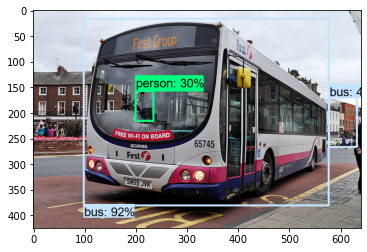

In [109]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

# Visualization params
MAX_BBOXES = 200
THRESHOLD = 0.3

# Alter image
# Flip horizontally
#image_np = np.fliplr(image_np).copy()
# Convert image to grayscale
#image_np = np.tile(np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=MAX_BBOXES,
            min_score_thresh=THRESHOLD,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 4. Generate adversarial example

# 5. Attack